In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import pickle

"""
Esta celda importa las bibliotecas necesarias para el proyecto:
- pandas y numpy para la manipulación de datos
- seaborn y matplotlib para la visualización de datos
- os y pickle para operaciones relacionadas con el sistema y la serialización de objetos, respectivamente.
"""

'\nEsta celda importa las bibliotecas necesarias para el proyecto:\n- pandas y numpy para la manipulación de datos\n- seaborn y matplotlib para la visualización de datos\n- os y pickle para operaciones relacionadas con el sistema y la serialización de objetos, respectivamente.\n'

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

"""
Esta celda importa funciones y clases específicas de Keras para la creación y entrenamiento de modelos de redes neuronales:
- Sequential para la construcción del modelo
- Varios tipos de capas (Dense, Conv2D, MaxPooling2D, etc.) para definir la arquitectura de la red
- to_categorical para convertir etiquetas enteras en representaciones categóricas (one-hot).
"""

'\nEsta celda importa funciones y clases específicas de Keras para la creación y entrenamiento de modelos de redes neuronales:\n- Sequential para la construcción del modelo\n- Varios tipos de capas (Dense, Conv2D, MaxPooling2D, etc.) para definir la arquitectura de la red\n- to_categorical para convertir etiquetas enteras en representaciones categóricas (one-hot).\n'

In [6]:
dir_datos = "LABORATORIO2_DS"

"""
Esta celda define una variable que contiene la ruta del directorio donde se encuentran los datos para el proyecto.
"""

'\nEsta celda define una variable que contiene la ruta del directorio donde se encuentran los datos para el proyecto.\n'

In [7]:
os.listdir(dir_datos)[0]

'.ipynb_checkpoints'

In [8]:
trayecto_test = dir_datos + '/prueba.p'
trayecto_train = dir_datos + '/entrenamiento.p'
trayecto_val = dir_datos + '/validacion.p'

In [9]:
def cargar_datos(ruta):
    with open(ruta, 'rb') as file:
        datos = pickle.load(file)
    return datos

In [10]:
datos_prueba = cargar_datos(trayecto_test)
datos_entrenamiento = cargar_datos(trayecto_train)
datos_validacion = cargar_datos(trayecto_val)

In [11]:
# After loading the 'images' from the pickle file:

# Print the type of the object
print(type(datos_entrenamiento))

# If it's a dictionary, print its keys
if isinstance(datos_entrenamiento, dict):
    print(datos_entrenamiento.keys())

<class 'dict'>
dict_keys(['coords', 'labels', 'features', 'sizes'])


In [12]:
for key, value in datos_entrenamiento.items():
    print(f"{key}: Type = {type(value)}, Length/Shape = {len(value) if isinstance(value, (list, dict)) else (value.shape if hasattr(value, 'shape') else 'N/A')}")


coords: Type = <class 'numpy.ndarray'>, Length/Shape = (34799, 4)
labels: Type = <class 'numpy.ndarray'>, Length/Shape = (34799,)
features: Type = <class 'numpy.ndarray'>, Length/Shape = (34799, 32, 32, 3)
sizes: Type = <class 'numpy.ndarray'>, Length/Shape = (34799, 2)


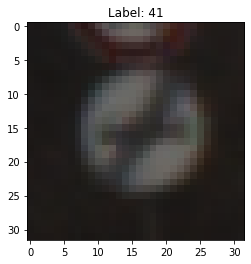

In [13]:
plt.imshow(datos_entrenamiento['features'][1])
plt.title(f"Label: {datos_entrenamiento['labels'][1]}")
plt.show()

In [14]:
# 1. Normalizar las imágenes
X_entrenamiento = datos_entrenamiento['features'] / 255.0
X_prueba = datos_prueba['features'] / 255.0
X_validacion = datos_validacion['features'] / 255.0

In [15]:
# 2. One-Hot Encoding para las etiquetas
Y_entrenamiento = to_categorical(datos_entrenamiento['labels'])
Y_prueba = to_categorical(datos_prueba['labels'])
Y_validacion = to_categorical(datos_validacion['labels'])

# Verificar las dimensiones de los datos procesados
print("X_entrenamiento shape:", X_entrenamiento.shape)
print("Y_entrenamiento shape:", Y_entrenamiento.shape)
print("X_prueba shape:", X_prueba.shape)
print("Y_prueba shape:", Y_prueba.shape)
print("X_validacion shape:", X_validacion.shape)
print("Y_validacion shape:", Y_validacion.shape)

X_entrenamiento shape: (34799, 32, 32, 3)
Y_entrenamiento shape: (34799, 43)
X_prueba shape: (12630, 32, 32, 3)
Y_prueba shape: (12630, 43)
X_validacion shape: (4410, 32, 32, 3)
Y_validacion shape: (4410, 43)


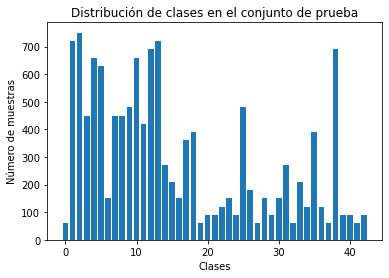

In [16]:
# Visualizar distribución de clases
unique, counts = np.unique(np.argmax(Y_prueba, axis=1), return_counts=True)
plt.bar(unique, counts)
plt.title('Distribución de clases en el conjunto de prueba')
plt.xlabel('Clases')
plt.ylabel('Número de muestras')
plt.show()

In [17]:
dict(zip(unique, counts))

{0: 60,
 1: 720,
 2: 750,
 3: 450,
 4: 660,
 5: 630,
 6: 150,
 7: 450,
 8: 450,
 9: 480,
 10: 660,
 11: 420,
 12: 690,
 13: 720,
 14: 270,
 15: 210,
 16: 150,
 17: 360,
 18: 390,
 19: 60,
 20: 90,
 21: 90,
 22: 120,
 23: 150,
 24: 90,
 25: 480,
 26: 180,
 27: 60,
 28: 150,
 29: 90,
 30: 150,
 31: 270,
 32: 60,
 33: 210,
 34: 120,
 35: 390,
 36: 120,
 37: 60,
 38: 690,
 39: 90,
 40: 90,
 41: 60,
 42: 90}

In [18]:
import sklearn
from imblearn.over_sampling import SMOTE

# Aplanar las imágenes
X_entrenamiento_flattened = X_entrenamiento.reshape(X_entrenamiento.shape[0], -1)
Y_entrenamiento_labels = np.argmax(Y_entrenamiento, axis=1)  # Convertir de one-hot a labels

# Aplicar SMOTE
smote = SMOTE()
X_entrenamiento_resampled, Y_entrenamiento_resampled = smote.fit_resample(X_entrenamiento_flattened, Y_entrenamiento_labels)

# Reformatear las imágenes a su forma original y las etiquetas a one-hot encoding
X_entrenamiento_resampled = X_entrenamiento_resampled.reshape((-1, 32, 32, 3))
Y_entrenamiento_resampled = to_categorical(Y_entrenamiento_resampled)


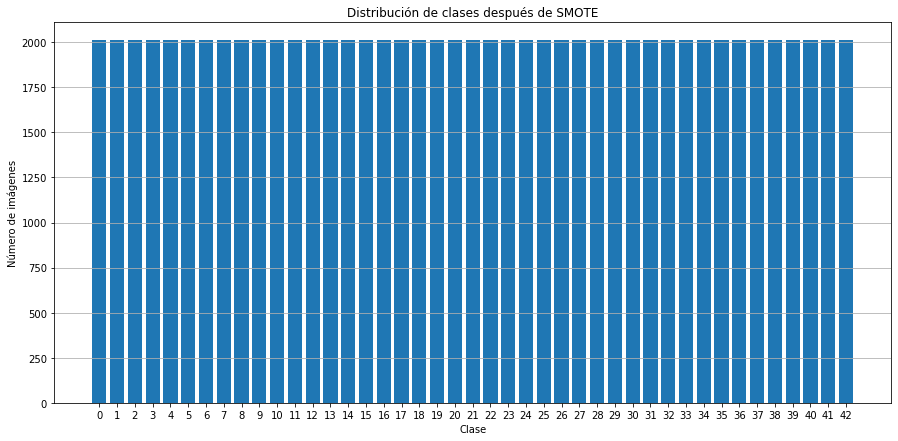

In [19]:
# Convertir de one-hot a labels
Y_entrenamiento_resampled_labels = np.argmax(Y_entrenamiento_resampled, axis=1)

# Contar las ocurrencias de cada etiqueta
unique, counts = np.unique(Y_entrenamiento_resampled_labels, return_counts=True)

# Visualizar las ocurrencias
plt.figure(figsize=(15,7))
plt.bar(unique, counts)
plt.title('Distribución de clases después de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.xticks(unique)
plt.grid(axis='y')
plt.show()

In [20]:
from keras.preprocessing.image import ImageDataGenerator

In [21]:
"""datagen = ImageDataGenerator(
    rotation_range=10,         # Pequeñas rotaciones aleatorias
    width_shift_range=0.1,     # Desplazamiento horizontal aleatorio
    height_shift_range=0.1,    # Desplazamiento vertical aleatorio
    zoom_range=0.1,            # Rango de zoom aleatorio
    horizontal_flip=True,      # Volteo horizontal aleatorio
    fill_mode='nearest'        # Método para rellenar puntos fuera de la imagen original
)"""

datagen = ImageDataGenerator(
    rotation_range=15,          # Aumentamos el rango de rotación
    width_shift_range=0.15,     # Aumentamos el desplazamiento horizontal
    height_shift_range=0.15,    # Aumentamos el desplazamiento vertical
    zoom_range=0.15,            # Aumentamos el rango de zoom
    horizontal_flip=True,       
    fill_mode='nearest'         
)

In [22]:
datagen.fit(X_entrenamiento)

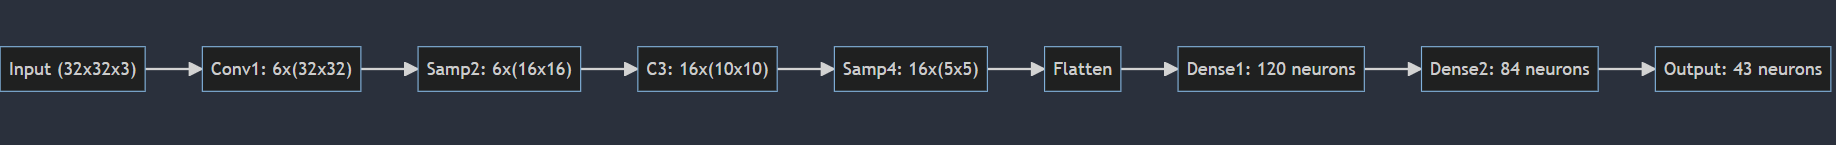

In [23]:
modelo_LeNet = Sequential()
# Capa convolucional 1
modelo_LeNet.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32, 32, 3), padding="same"))

# Capa de subsampling (pooling) 1
modelo_LeNet.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Capa convolucional 2
modelo_LeNet.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# Capa de subsampling (pooling) 2
modelo_LeNet.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Aplanar
modelo_LeNet.add(Flatten())

# Capa completamente conectada (Dense) 1
modelo_LeNet.add(Dense(120, activation='tanh'))

# Capa completamente conectada (Dense) 2
modelo_LeNet.add(Dense(84, activation='tanh'))

# Capa de salida
modelo_LeNet.add(Dense(43, activation='softmax'))

In [24]:
modelo_LeNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Resumen del modelo
modelo_LeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [26]:
modelo_LeNet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# 2. Entrenar el modelo 
# (Suponiendo que ya tienes tus datos y etiquetas definidos como X_entrenamiento, Y_entrenamiento, etc.)
historia = modelo_LeNet.fit(
    X_entrenamiento, 
    Y_entrenamiento, 
    epochs=50,
    batch_size=32,
    validation_data=(X_validacion, Y_validacion)
    # Puedes agregar callbacks si los necesitas
)

# 3. Evaluar el modelo en datos de prueba
score = modelo_LeNet.evaluate(X_prueba, Y_prueba, verbose=1)
print('Pérdida en datos de prueba:', score[0])
print('Precisión en datos de prueba:', score[1])

Epoch 1/50
1088/1088 [==============================] - 10s 9ms/step - loss: 0.8814 - accuracy: 0.7741 - val_loss: 0.4635 - val_accuracy: 0.8612
Epoch 2/50
1088/1088 [==============================] - 9s 9ms/step - loss: 0.1666 - accuracy: 0.9615 - val_loss: 0.3650 - val_accuracy: 0.8946
Epoch 3/50
1088/1088 [==============================] - 10s 9ms/step - loss: 0.0873 - accuracy: 0.9811 - val_loss: 0.3366 - val_accuracy: 0.9041
Epoch 4/50
1088/1088 [==============================] - 9s 9ms/step - loss: 0.0547 - accuracy: 0.9874 - val_loss: 0.3644 - val_accuracy: 0.9018
Epoch 5/50
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0362 - accuracy: 0.9919 - val_loss: 0.3327 - val_accuracy: 0.9156
Epoch 6/50
1088/1088 [==============================] - 10s 9ms/step - loss: 0.0277 - accuracy: 0.9936 - val_loss: 0.4178 - val_accuracy: 0.8927
Epoch 7/50
1088/1088 [==============================] - 10s 9ms/step - loss: 0.0205 - accuracy: 0.9955 - val_loss: 0.3008 - val_acc

In [27]:
perdidas = pd.DataFrame(historia.history)
perdidas.head()

,loss,accuracy,val_loss,val_accuracy
0,0.881387,0.774131,0.463469,0.861224
1,0.166552,0.961493,0.365027,0.894558
2,0.087333,0.981063,0.336623,0.904082
3,0.054724,0.987442,0.364427,0.901814
4,0.036227,0.991868,0.332707,0.915646


<AxesSubplot:>

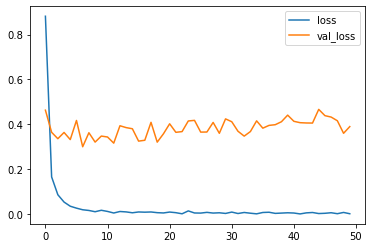

In [28]:
perdidas[['loss','val_loss']].plot()

In [29]:
modelo_LeNet.metrics_names

['loss', 'accuracy']

<AxesSubplot:>

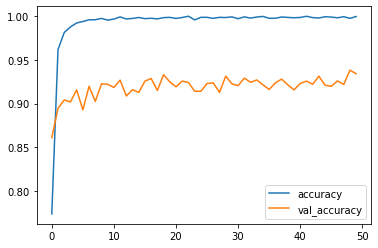

In [30]:
perdidas[['accuracy', 'val_accuracy']].plot()

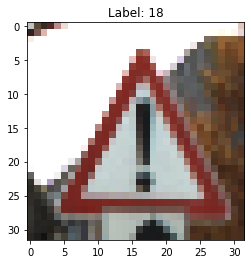

1/1 [==============================] - 0s 97ms/step
Clase predicha: 18


In [33]:
plt.imshow(datos_prueba['features'][6])
plt.title(f"Label: {datos_prueba['labels'][6]}")
plt.show()

# 1. Hacer una predicción para la imagen
probabilidades = modelo_LeNet.predict(np.expand_dims(X_prueba[6], axis=0))

# 2. Obtener la clase con la mayor probabilidad
clase_predicha = np.argmax(probabilidades, axis=-1)[0]

print("Clase predicha:", clase_predicha)

In [34]:
# Realizar predicciones con el modelo
y_pred = modelo_LeNet.predict(X_prueba)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las probabilidades predichas en etiquetas de clase

# Convertir las etiquetas one-hot en etiquetas de clase
y_true = np.argmax(Y_prueba, axis=1)

# Calcular métricas
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

395/395 [==============================] - 1s 3ms/step
Precision: 0.9078886803145976
Recall: 0.9034045922406968
F1-Score: 0.9030834984190192


In [35]:
modelo_LeNet_modificado = Sequential()

# Capa convolucional 1
modelo_LeNet_modificado.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32, 32, 3), padding="same"))
modelo_LeNet_modificado.add(BatchNormalization())
modelo_LeNet_modificado.add(Dropout(0.3))

# Capa de subsampling (pooling) 1
modelo_LeNet_modificado.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Capa convolucional 2
modelo_LeNet_modificado.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
modelo_LeNet_modificado.add(BatchNormalization())
modelo_LeNet_modificado.add(Dropout(0.3))

# Capa de subsampling (pooling) 2
modelo_LeNet_modificado.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Aplanar
modelo_LeNet_modificado.add(Flatten())

# Capa completamente conectada (Dense) 1
modelo_LeNet_modificado.add(Dense(120, activation='tanh'))
modelo_LeNet_modificado.add(BatchNormalization())
modelo_LeNet_modificado.add(Dropout(0.3))

# Capa completamente conectada (Dense) 2
modelo_LeNet_modificado.add(Dense(84, activation='tanh'))
modelo_LeNet_modificado.add(BatchNormalization())
modelo_LeNet_modificado.add(Dropout(0.3))

# Capa de salida
modelo_LeNet_modificado.add(Dense(43, activation='softmax'))

# Definición del callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

modelo_LeNet_modificado.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Resumen del modelo
modelo_LeNet_modificado.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 6)         0         
                                                                 
 average_pooling2d_2 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 16)      

In [37]:
# 2. Entrenar el modelo (asegúrate de tener tus datos y etiquetas definidos como X_entrenamiento, Y_entrenamiento, etc.)
# También puedes usar un generador de datos si lo tienes configurado.
historia_mod = modelo_LeNet_modificado.fit(
    X_entrenamiento, Y_entrenamiento, 
    epochs=50,
    batch_size=32,
    validation_data=(X_validacion, Y_validacion), 
    callbacks=[early_stopping]
)

# 3. Evaluar el modelo en datos de prueba
score = modelo_LeNet_modificado.evaluate(X_prueba, Y_prueba, verbose=1)
print('Pérdida en datos de prueba:', score[0])
print('Precisión en datos de prueba:', score[1])

Epoch 1/50
1088/1088 [==============================] - 17s 14ms/step - loss: 1.2736 - accuracy: 0.6450 - val_loss: 0.4559 - val_accuracy: 0.8587
Epoch 2/50
1088/1088 [==============================] - 16s 14ms/step - loss: 0.5090 - accuracy: 0.8481 - val_loss: 0.3157 - val_accuracy: 0.9029
Epoch 3/50
1088/1088 [==============================] - 16s 15ms/step - loss: 0.3724 - accuracy: 0.8895 - val_loss: 0.2569 - val_accuracy: 0.9200
Epoch 4/50
1088/1088 [==============================] - 16s 15ms/step - loss: 0.3118 - accuracy: 0.9076 - val_loss: 0.2203 - val_accuracy: 0.9347
Epoch 5/50
1088/1088 [==============================] - 16s 15ms/step - loss: 0.2704 - accuracy: 0.9194 - val_loss: 0.2255 - val_accuracy: 0.9313
Epoch 6/50
1088/1088 [==============================] - 16s 15ms/step - loss: 0.2422 - accuracy: 0.9282 - val_loss: 0.2180 - val_accuracy: 0.9365
Epoch 7/50
1088/1088 [==============================] - 16s 15ms/step - loss: 0.2208 - accuracy: 0.9329 - val_loss: 0.1841 -

In [38]:
perdidas_mod = pd.DataFrame(historia_mod.history)
perdidas_mod.head()

,loss,accuracy,val_loss,val_accuracy
0,1.273592,0.645047,0.455945,0.858730
1,0.509001,0.848128,0.315732,0.902948
2,0.372408,0.889537,0.256887,0.919955
3,0.311837,0.907641,0.220289,0.934694
4,0.270426,0.919423,0.225471,0.931293


<AxesSubplot:>

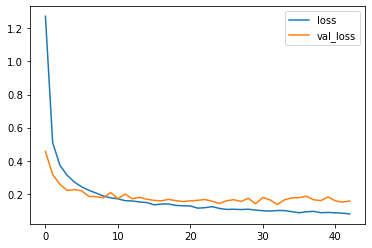

In [39]:
perdidas_mod[['loss','val_loss']].plot()

<AxesSubplot:>

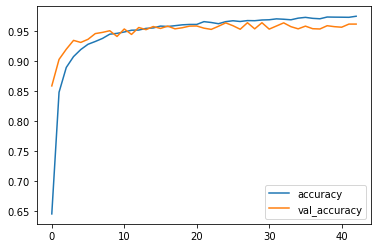

In [40]:
perdidas_mod[['accuracy', 'val_accuracy']].plot()

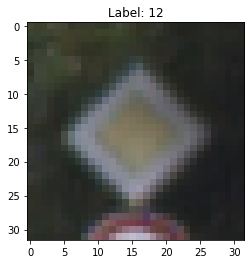

1/1 [==============================] - 0s 78ms/step
Clase predicha: 12


In [41]:
plt.imshow(datos_prueba['features'][7])
plt.title(f"Label: {datos_prueba['labels'][7]}")
plt.show()

# 1. Hacer una predicción para la imagen
probabilidades = modelo_LeNet_modificado.predict(np.expand_dims(X_prueba[7], axis=0))

# 2. Obtener la clase con la mayor probabilidad
clase_predicha = np.argmax(probabilidades, axis=-1)[0]

print("Clase predicha:", clase_predicha)

In [42]:
# 1. Realizar predicciones con el modelo
y_pred = modelo_LeNet_modificado.predict(X_prueba)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las probabilidades predichas en etiquetas de clase

# 2. Convertir las etiquetas one-hot en etiquetas de clase
y_true = np.argmax(Y_prueba, axis=1)

# 3. Calcular métricas
f1 = f1_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

395/395 [==============================] - 2s 4ms/step
Precision: 0.9487373311072747
Recall: 0.9472684085510689
F1-Score: 0.946475018290988
